In [52]:
"""creates a spatial layer from the chosen Matrix text table (e.g. travel_times_to_5797076.txt) by joining the
Matrix file with MetropAccess_YKR_grid Shapefile where from_id in Matrix file corresponds to YKR_ID in the
Shapefile.

The tool saves the result in the output-folder that user has defined. Output file format can be Shapefile or
Geopackage. You should name the files in a way that it is possible to identify the ID from the name (e.g. 5797076).

The table joining can be applied to files that correspond to a list of selected YKR ID files
(FileFinder handles finding the correct input files!)."""

'creates a spatial layer from the chosen Matrix text table (e.g. travel_times_to_5797076.txt) by joining the\nMatrix file with MetropAccess_YKR_grid Shapefile where from_id in Matrix file corresponds to YKR_ID in the\nShapefile.\n\nThe tool saves the result in the output-folder that user has defined. Output file format can be Shapefile or\nGeopackage. You should name the files in a way that it is possible to identify the ID from the name (e.g. 5797076).\n\nThe table joining can be applied to files that correspond to a list of selected YKR ID files\n(FileFinder handles finding the correct input files!).'

In [53]:
#define function for the filefinder
def FileFinder(YKR_ID, foldername):
    """finds a list of travel time matrix files based on a single YKR_ID or a list of YKR_ID values from a specified input folder"""
    
    #Make assertions that given IDs are a list of integers and the foldername is string
    assert type(YKR_ID) == str or type(YKR_ID) == int or type(YKR_ID) == builtins.list, 'The given variable must be a string, integer or list'
    if type(YKR_ID) == builtins.list:
        for index in YKR_ID:
            assert type(index) == str or type(index) == int, 'The variables in a given list need to be string or integer'
        
    assert type(foldername) == str, 'The foldername needs to be a string'
    
    
    if type(YKR_ID) != builtins.list:
        copy = YKR_ID
        YKR_ID = []
        YKR_ID.append(copy)

        
    #create a list with text files from given folder and its subfolders (recursive=true)
    list = glob.glob(foldername + '/**/*.txt',recursive=True)
    filenumbers = []
    for i in list:
        split = i.split('_')
        split = split[2].split('.')
        filenumbers.append(split[0])
       
    #Go through the given files and see which match with given YKR_IDs        
    filenames = []
    index = 0
    for i in filenumbers:
        file = 'TravelTimes_to_' + i + '.txt'
        index = index + 1
        print('processing file', file,'... Progress: ', str(index), '/', str(len(filenumbers)))
        #go through given YKR IDs to find if they match with the file names.
        #If a match is found, the file number is removed to make sure it's not added two times to the output list
        for j in YKR_ID:
            if str(j) == i:
                filename = 'TravelTimes_to_' + str(j) + '.txt'
                filenames.append(filename)
                YKR_ID.remove(j)
    
    if len(filenames) < 1:
        print('No files found with given YKR ID(s)')
    #Collect full filepaths for the output from the list created in the first steps            
    output = []
    for i in filenames:
        for j in list:
            if i in j:
                output.append(j)
                list.remove(j)
    return output

In [54]:
import glob
import geopandas as gpd
import pandas as pd
import builtins

In [55]:
fp = r'data/MetropAccess_YKR_grid_EurefFIN.shp'
ykr_grid = gpd.read_file(fp)
type(ykr_grid)

geopandas.geodataframe.GeoDataFrame

In [56]:
def TableJoiner(Matrix_txt, grid):
    """creates a layer from the given text table or a list of tables by joining the file with given YKR grid geodataframe
    where from_id in Matrix file corresponds to YKR_ID in the Shapefile"""
    
    #Create asssertions that the Matrix_txt variable is a string or a list of strings and the grid variable is a geodataframe
    assert type(Matrix_txt) == str or type(Matrix_txt) == __builtins__.list, 'The given variable must be a string or list'
    if type(Matrix_txt) == __builtins__.list:
        for index in Matrix_txt:
            assert type(index) == str, 'The variables in a given list need to be in string format'
            
    assert isinstance(grid, gpd.GeoDataFrame), 'grid variable needs to be a geodataframe'
    
    #matrix_txt variable is a single string
    if type(Matrix_txt) == str:
        #read file from filepath, use ; as separator, use specific columns and remove values less than 0
        data = pd.read_csv(Matrix_txt, sep=';', na_values=-1)
        data = data.loc[data['walk_t'] >= 0]
        data = data.loc[data['pt_r_t'] >= 0]
        data = data.loc[data['car_r_t'] >= 0]
        #data = data.loc[data['bike_s_t'] >= 0]
        
        data = data.loc[data['walk_d'] >= 0]
        data = data.loc[data['car_r_d'] >= 0]
        data = data.loc[data['pt_r_d'] >= 0]
        #data = data.loc[data['bike_t'] >= 0]
        
        #merge data with YKR grid file
        output = ykr_grid.merge(data, left_on='YKR_ID', right_on='from_id')
        
        #create filepath for the joined table and save it
        split = Matrix_txt.split('_')
        split = split[2].split('.')
        out_fp = 'data/' + split[0] + '.shp'
        output.to_file(out_fp)
    
    #matrix_txt variable is a list of strings
    if type(Matrix_txt) == builtins.list:
        #for each filepath from the list of strings, read file, use ; as separator and use specific columns, remove values less than 0
        for index in Matrix_txt:
            data = pd.read_csv(index, sep=';', na_values=-1)
            data = data.loc[data['walk_t'] >= 0]
            data = data.loc[data['pt_r_t'] >= 0]
            data = data.loc[data['car_r_t'] >= 0]
            
            #merge data with YKR grid file
            output = ykr_grid.merge(data, left_on='YKR_ID', right_on='from_id')
            
            #create filepath for the joined table and save it
            split = index.split('_')
            split = split[2].split('.')
            out_fp = 'data/' + split[0] + '.shp'
            output.to_file(out_fp)
    print('TableJoiner done!')

In [57]:
fp = 'data/1/TravelTimes_to_5980260.txt'

In [58]:
TableJoiner(fp, ykr_grid)

In [59]:
result = gpd.read_file('data/5980260.shp')

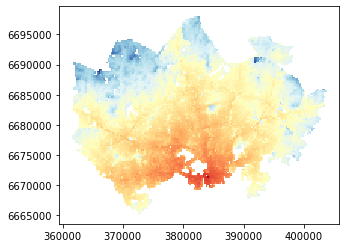

In [69]:
result.plot(column='car_r_t', cmap='RdYlBu')